# Safe Interval Path Planning On a Grid :: SIPP Algorithm (based on A* with idea of safe intervals)

In this project, we will consider the problem of finding the fastest safe path on a graph with a special structure, widely used in robotics and computer games — a grid. The grid consists of both free and blocked cells, and an agent can move from one free cell to another. Our grid will also have some obstacles and they will be moving. Algortihm needs to find a route that does not intrfere with obstacles at any point in our discrete time




In [182]:
import random
import traceback
from heapq import heappop, heappush
from pathlib import Path
from textwrap import dedent
from typing import Callable, Dict, Iterable, List, Optional, Tuple, Type, Union

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
from PIL import Image, ImageDraw

%matplotlib inline

## TODO import our map

In [183]:
# class Map:
#     """
#     Represents a square grid environment for our moving agent.

#     Attributes
#     ----------
#     _width : int
#         The number of columns in the grid.

#     _height : int
#         The number of rows in the grid.

#     _cells : np.ndarray
#         A binary matrix representing the grid where 0 represents a traversable cell, and 1 represents a blocked cell.
#     """

#     def __init__(self, cells: npt.NDArray):
#         """
#         Initializes the map using a 2D array of cells.

#         Parameters
#         ----------
#         cells : np.ndarray
#             A binary matrix representing the grid. 0 indicates a traversable cell, and 1 indicates a blocked cell.
#         """
#         self._width = cells.shape[1]
#         self._height = cells.shape[0]
#         self._cells = cells

#     def in_bounds(self, i: int, j: int) -> bool:
#         """
#         Checks if the cell (i, j) is within the grid boundaries.

#         Parameters
#         ----------
#         i : int
#             Row number of the cell in the grid.
#         j : int
#             Column number of the cell in the grid.

#         Returns
#         ----------
#         bool
#             True if the cell is inside the grid, False otherwise.
#         """
#         return 0 <= j < self._width and 0 <= i < self._height

#     def traversable(self, i: int, j: int) -> bool:
#         """
#         Checks if the cell (i, j) is not an obstacle.

#         Parameters
#         ----------
#         i : int
#             Row number of the cell in the grid.
#         j : int
#             Column number of the cell in the grid.

#         Returns
#         ----------
#         bool
#             True if the cell is traversable, False if it's blocked.
#         """
#         return not self._cells[i, j]

#     def get_neighbors(self, i: int, j: int) -> List[Tuple[int, int]]:
#         """
#         Gets a list of neighboring cells as (i, j) tuples.
#         Assumes that the grid is 4-connected, allowing moves only in cardinal directions.

#         Parameters
#         ----------
#         i : int
#             Row number of the cell in the grid.
#         j : int
#             Column number of the cell in the grid.

#         Returns
#         ----------
#         neighbors : List[Tuple[int, int]]
#             List of neighboring cells.
#         """
#         neighbors = []
#         delta = ((0, 1), (1, 0), (0, -1), (-1, 0))
#         for dx, dy in delta:
#             ni, nj = i + dx, j + dy
#             if self.in_bounds(ni, nj) and self.traversable(ni, nj):
#                 neighbors.append((ni, nj))
#         return neighbors

#     def get_size(self) -> Tuple[int, int]:
#         """
#         Returns the size of the grid in cells.

#         Returns
#         ----------
#         (height, width) : Tuple[int, int]
#             Number of rows and columns in the grid.
#         """
#         return self._height, self._width

In [184]:
# def convert_string_to_cells(cell_str: str) -> npt.NDArray:
#     """
#     Converts a string representation of a grid map, with '#' for obstacles and '.' for free cells, into a binary matrix.

#     Parameters
#     ----------
#     cell_str : str
#         String containing grid map information ('#' for obstacles and '.' for free cells).

#     Returns
#     ----------
#     cells : np.ndarray
#         Binary matrix representing the grid map.
#     """
#     lines = cell_str.replace(" ", "").split("\n")

#     cells = np.array(
#         [[1 if char == "#" else 0 for char in line] for line in lines if line],
#         dtype=np.int8,
#     )
#     return cells

Computes the cost of a transition from cell `(i1, j1)` to cell `(i2, j2)`. In the case of a 4-connected grid, the cost is always equal to 1. Consequently, the cost of each path is an integer.

However, please note that if the grid's connectivity exceeds 4, the cost of a transition may vary and may become fractional or even arbitrary (e.g., $\sqrt{2}$ for diagonal moves).

Recall that in this lab, we assume a 4-connected grid, meaning that only cardinal moves (up, down, left, right) are allowed, and as a result, all costs are integers.


In [185]:
def compute_cost(i1: int, j1: int, i2: int, j2: int) -> Union[int, float]:
    """
    Computes the cost of simple moves between cells (i1, j1) and (i2, j2).

    Parameters
    ----------
    i1 : int
        Row number of the first cell in the grid.
    j1 : int
        Column number of the first cell in the grid.
    i2 : int
        Row number of the second cell in the grid.
    j2 : int
        Column number of the second cell in the grid.

    Returns
    ----------
    int | float
        Cost of the move between cells.

    Raises
    ----------
    ValueError
        If trying to compute the cost of a non-supported move (only cardinal moves are supported).
    """
    if abs(i1 - i2) + abs(j1 - j2) == 1:  # Cardinal move
        return 1
    else:
        raise ValueError("Trying to compute the cost of a non-supported move! ONLY cardinal moves are supported.")

## Search Node

A Search node is a fundamental concept in heuristic search algorithms. It encapsulates data about the state of the problem (e.g., the position of a robot or agent on a grid) and the information needed to construct a search tree, including g-values, h-values, f-values, and a backpointer to its predecessor.


In [186]:
class Node:
    """
    Represents a search node.

    Attributes
    ----------
    i : int
        Row coordinate of the corresponding grid element.
    j : int
        Column coordinate of the corresponding grid element.
    g : float | int
        g-value of the node.
    h : float | int
        h-value of the node
    f : float | int
        f-value of the node
    parent : Node
        Pointer to the parent node.
    """

    def __init__(
        self,
        i: int,
        j: int,
        g: Union[float, int] = 0,
        h: Union[float, int] = 0,
        f: Optional[Union[float, int]] = None,
        parent: "Node" = None,
    ):
        """
        Initializes a search node.

        Parameters
        ----------
        i : int
            Row coordinate of the corresponding grid element.
        j : int
            Column coordinate of the corresponding grid element.
        g : float | int
            g-value of the node.
        h : float | int
            h-value of the node (always 0 for Dijkstra).
        f : float | int
            f-value of the node (always equal to g-value for Dijkstra).
        parent : Node
            Pointer to the parent node.
        """
        self.i = i
        self.j = j
        self.g = g
        self.h = h
        if f is None:
            self.f = self.g + h
        else:
            self.f = f
        self.parent = parent

    def __eq__(self, other):
        """
        Checks if two search nodes are the same, which is needed to detect duplicates in the search tree.
        """
        return self.i == other.i and self.j == other.j

    def __hash__(self):
        """
        Makes the Node object hashable, allowing it to be used in sets/dictionaries.
        """
        return hash((self.i, self.j))

    def __lt__(self, other):
        """
        Compares the keys (i.e., the f-values) of two nodes, needed for sorting/extracting the best element from OPEN.
        """
        if self.f == other.f:
            return self.g > other.g
        return self.f < other.f

## Visualization

In [187]:
def draw_rectangle(draw, node, scale, color):
    """Draws a rectangle on the grid, given the node and the desired color."""
    draw.rectangle(
        (
            node.j * scale,
            node.i * scale,
            (node.j + 1) * scale - 1,
            (node.i + 1) * scale - 1,
        ),
        fill=color,
        width=0,
    )


def draw(
    grid_map: Map,
    start: Optional[Node] = None,
    goal: Optional[Node] = None,
    path: Optional[Iterable[Node]] = None,
    nodes_discovered: Optional[Iterable[Node]] = None,
    nodes_expanded: Optional[Iterable[Node]] = None,
    nodes_reexpanded: Optional[Iterable[Node]] = None,
):
    """
    Visualizes the environment, path, and expanded/not yet expanded/re-expanded nodes.

    Parameters
    ----------
    grid_map : Map
        Environment represented as a grid.
    start, goal : Optional[Node], Optional[Node]
        Nodes for the start and goal positions of the agent.
    path : Optional[Iterable[Node]]
        Sequence of nodes representing the path between start and goal.
    nodes_discovered : Optional[Iterable[Node]]
        Nodes that were discovered during the search process.
    nodes_expanded : Optional[Iterable[Node]]
        Nodes that were expanded during the search process.
    nodes_reexpanded : Optional[Iterable[Node]]
        Nodes that were re-expanded during the search process.
    """
    scale = 5
    height, width = grid_map.get_size()
    im = Image.new("RGB", (width * scale, height * scale), color="white")
    draw = ImageDraw.Draw(im)

    # Draw blocked cells
    for i in range(height):
        for j in range(width):
            if not grid_map.traversable(i, j):
                draw.rectangle(
                    (j * scale, i * scale, (j + 1) * scale - 1, (i + 1) * scale - 1),
                    fill=(70, 80, 80),
                )

    node_colors = [
        (nodes_discovered, (213, 219, 219)),
        (nodes_expanded, (131, 145, 146)),
        (nodes_reexpanded, (255, 145, 146)),
    ]

    for nodes, color in node_colors:
        if nodes is not None:
            for node in nodes:
                draw_rectangle(draw, node, scale, color)

    if path is not None:
        for step in path:
            color = (52, 152, 219) if grid_map.traversable(step.i, step.j) else (230, 126, 34)
            draw_rectangle(draw, step, scale, color)

    if start is not None and grid_map.traversable(start.i, start.j):
        draw_rectangle(draw, start, scale, (40, 180, 99))

    if goal is not None and grid_map.traversable(goal.i, goal.j):
        draw_rectangle(draw, goal, scale, (231, 76, 60))

    _, ax = plt.subplots(dpi=150)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.imshow(np.asarray(im))
    plt.show()

Example of the visualization

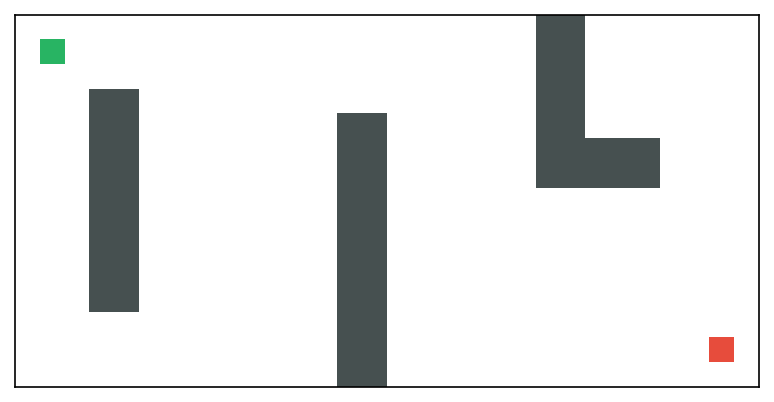

In [188]:
height = 15
width = 30
map_str = """
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . .  
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
. . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
"""
cells = convert_string_to_cells(map_str)

test_map = Map(cells)
start = Node(1, 1)
goal = Node(13, 28)
draw(test_map, start, goal)

## Implementing the Search Tree (i.e., OPEN and CLOSED)
An efficient implementation of the search tree (`OPEN` and `CLOSED`) is crucial for any search algorithm. You should utilize the efficient search tree implementation you developed in the previous lab.

In [189]:
class SearchTreePQD:
    """
    SearchTree using a priority queue for OPEN and a dictionary for CLOSED.
    """

    def __init__(self):
        self._open = []  # Priority queue for nodes in OPEN
        self._closed = {}  # Dictionary for nodes in CLOSED (expanded nodes)
        self._enc_open_duplicates = 0  # Number of duplicates encountered in OPEN

    def __len__(self) -> int:
        """
        Returns the size of the search tree. Useful for assessing the memory
        footprint of the algorithm, especially at the final iteration.
        """
        return len(self._open) + len(self._closed)

    def open_is_empty(self) -> bool:
        """
        Checks if OPEN is empty.
        If true, the main search loop should be interrupted.
        """
        return len(self._open) == 0

    def add_to_open(self, item: Node):
        """
        Adds a node to the search tree, specifically to OPEN. This node is either
        entirely new or a duplicate of an existing node in OPEN.
        This implementation detects duplicates lazily; thus, nodes are added to
        OPEN without initial duplicate checks.
        """
        heappush(self._open, item)

    def get_best_node_from_open(self) -> Optional[Node]:
        """
        Retrieves the best node from OPEN, defined by the minimum key.
        This node will then be expanded in the main search loop.

        Duplicates are managed here. If a node has been expanded previously
        (and is in CLOSED), it's skipped and the next best node is considered.

        Returns None if OPEN is empty.
        """
        while not self.open_is_empty():
            item = heappop(self._open)
            if item not in self._closed:
                return item
            else:
                self._enc_open_duplicates += 1
        return None

    def add_to_closed(self, item: Node):
        """
        Adds a node to the CLOSED dictionary.
        """
        self._closed[item] = item

    def was_expanded(self, item: Node) -> bool:
        """
        Checks if a node has been previously expanded.
        """
        return item in self._closed.keys()

    @property
    def opened(self):
        return self._open

    @property
    def expanded(self):
        return self._closed.keys()

    @property
    def number_of_open_dublicates(self):
        return self._enc_open_duplicates

## Validating the Results

In [190]:
def make_path(goal: Node) -> Tuple[List[Node], Union[float, int]]:
    """
    Creates a path by tracing parent pointers from the goal node to the start node.
    It also returns the path's length.

    Parameters
    ----------
    goal : Node
        Pointer to the goal node in the search tree.

    Returns
    -------
    Tuple[List[Node], float]
        Path and its length.
    """
    length = goal.g
    current = goal
    path = []
    while current.parent:
        path.append(current)
        current = current.parent
    path.append(current)
    return path[::-1], length

In [191]:
def read_task_from_file(
    path: str,
) -> Tuple[npt.NDArray, int, int, int, int, float]:
    """
    Reads map, start/goal positions, and true value of path length between the given start and goal from a file.

    Parameters
    ----------
    path : str
        Path to a file with the pathfinding problem instance.

    Returns
    -------
    cells : npt.NDArray
        Matrix of grid map cells.
    start_i, start_j : int, int
        Position of the start cell in the grid.
    goal_i, goal_j : int, int
        Position of the goal cell in the grid.
    length : float
        True value of the path's length between the given start and goal.
    """
    with open(path) as tasks_file:
        height = int(next(tasks_file))
        width = int(next(tasks_file))

        # Read the map section
        map_lines = [next(tasks_file) for _ in range(height)]
        map_str = "".join(map_lines)
        cells = convert_string_to_cells(map_str)

        start_i = int(next(tasks_file))
        start_j = int(next(tasks_file))
        goal_i = int(next(tasks_file))
        goal_j = int(next(tasks_file))
        length = float(next(tasks_file))

    return cells, start_i, start_j, goal_i, goal_j, length

When you finish implementing search algorithms, you'll naturally want to test them. The following functions will help you in doing just that.

`simple_test` runs the pathfinding algorithm on a single, straightforward instance, while `massive_test` executes it on a series of more involved instances. Both tests operate under the assumption that the search function follows the pattern below:

```
search(task_map, start.i, start.j, goal.i, goal.j, *optional arguments*) -> (path_found, last_state, steps, search_tree_size, open, closed)
```

These automated tests anticipate that the search function, which is passed as an input, adheres to the following structure:

- `task_map` is the grid
- `start.i, start.j` are the  $(i, j)$ coordinates of the starting cell
- `goal.i, goal.j` are the $(i, j)$ coordinates of the goal cell
- `*optional arguments*` represent additional parameters of the search function, passed with *args. For instance, the heuristic function.
- `path_found` is `True` if a path was found and `False` otherwise
- `last_state` denotes the last state of the path. It returns `None` if a path was not found
- `steps` provides the number of search steps taken
- `search_tree_size` represents the number of nodes that make up the search tree at the final iteration of the algorithm, which equates to the size of the resultant search tree.
- `open` is an iterable collection of the nodes that form the search frontier (OPEN nodes)
- `closed` is an iterable collection of the expanded nodes (CLOSED)


In [192]:
def simple_test(search_function: Callable, task: Union[int, None], *args):
    """
    Function `simple_test` runs `search_function` on one task. Use a number from 0 to 24 to choose a specific debug task
    on a simple map, or use None to select a random task from this pool. The function displays:
     - 'Path found!' and some statistics if a path was found.
     - 'Path not found!' if a path was not discovered.
     - 'Execution error' if an error occurred during the execution of the search_function.
    In the first case, the function also provides a visualization of the task.

    Parameters
    ----------
    search_function : Callable
        Implementation of the search method.
    task : int | None
        A number from 0 to 24 to choose a specific debug task on a simple map,
        or None to select a random task from this pool.
    *args
        Additional arguments passed to the search function.
    """

    def get_map_data():
        map_str = dedent(
            """
            . . . . . . . . . . . . . . . . . . . . . # # . . . . . . .  
            . . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
            . . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
            . . . # # . . . . . . . . . . . . . . . . # # . . . . . . . 
            . . . # # . . . . . . . . # # . . . . . . # # . . . . . . . 
            . . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
            . . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
            . . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
            . . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
            . . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
            . . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
            . . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
            . . . . . . . . . . . . . # # . . . . . . . . . . . . . . . 
            . . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
            . . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
        """
        )
        cells = convert_string_to_cells(map_str)
        return Map(cells)

    task_map = get_map_data()
    starts = [
        (9, 0),
        (13, 0),
        (7, 28),
        (14, 29),
        (4, 1),
        (0, 17),
        (5, 6),
        (5, 20),
        (12, 2),
        (7, 28),
        (11, 9),
        (3, 2),
        (3, 17),
        (13, 20),
        (1, 1),
        (9, 10),
        (14, 6),
        (2, 0),
        (9, 28),
        (8, 6),
        (11, 6),
        (3, 0),
        (8, 9),
        (14, 7),
        (12, 4),
    ]
    goals = [
        (11, 20),
        (2, 19),
        (6, 5),
        (4, 18),
        (9, 20),
        (7, 0),
        (2, 25),
        (12, 4),
        (3, 25),
        (0, 12),
        (4, 23),
        (2, 24),
        (9, 2),
        (1, 6),
        (13, 29),
        (14, 29),
        (2, 28),
        (14, 16),
        (13, 0),
        (1, 27),
        (14, 25),
        (10, 20),
        (12, 28),
        (2, 29),
        (1, 29),
    ]
    lengths = [
        36,
        30,
        30,
        21,
        28,
        24,
        32,
        27,
        42,
        23,
        35,
        37,
        23,
        26,
        40,
        36,
        42,
        28,
        44,
        36,
        38,
        29,
        33,
        42,
        44,
    ]

    if (task is None) or not (0 <= task < 25):
        task = random.randint(0, 24)

    start = Node(*starts[task])
    goal = Node(*goals[task])
    length = lengths[task]

    try:
        (
            found,
            end_node,
            number_of_steps,
            search_tree_size,
            *other_results,
        ) = search_function(task_map, start.i, start.j, goal.i, goal.j, *args)

        if found:
            path, path_length = make_path(end_node)
            correct = int(path_length) == int(length)
            draw(task_map, start, goal, path, *other_results)
            print(
                f"Path found! Length: {path_length}. Search tree size: {search_tree_size}. Number of steps: {number_of_steps}. Correct: {correct}"
            )
        else:
            print("Path not found!")
        return

    except Exception as e:
        print(f"Execution error: {e}")
        traceback.print_exc()

In [193]:
def simple_test_not_found(search_function: Callable, task: Union[int, None], *args):
    """
    Tests the `search_function` on a task that is not expected to have a solution.

    Use a number from 0 to 1 to choose a specific debug task
    on a simple map, or use None to select a random task from this pool. The function displays:
     - 'Path found!' and some statistics if a path was found.
     - 'Path not found!' if a path was not discovered (as expected).
     - 'Execution error' if an error occurred during the execution of the search_function.
    The function also provides a visualization of the task instance.

    Parameters
    ----------
    search_function : Callable
        Implementation of the search method.
    task : int | None
        A number from 0 to 1 to choose a specific debug task on a simple map,
        or None to select a random task from this pool.
    *args
        Additional arguments passed to the search function.
    """

    def get_map_data():
        map_str = dedent(
            """
            . . . . . . . . . . . . . . . . . . . . . # # . . . . . . .  
            . . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
            . . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
            . . . # # . . . . . . . . . . . . . . . . # # . . . . . . . 
            . . . # # . . . . . . . . # # . . . . . . # # . . . . . . . 
            . . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
            . . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
            . . . # # . . . . . . # # # # . . . . . . # . . . . . . . . 
            . . . # # . . . . . . # . # # . . . . . . # . . . . . . . . 
            . . . # # . . . . . . # . # # . . . . . . # . . . . . . . . 
            . . . # # . . . . . . # . # # . . . . . . # . . . . . . . . 
            . . . # # . . . . . . # # # # . . . . . . # . . . . . . . . 
            . . . . . . . . . . . . . # # . . . . . . # . . . . . . . . 
            . . . . . . . . . . . . . # # . . . . . . # . . . . . . . .
            . . . . . . . . . . . . . # # . . . . . . # . . . . . . . .
        """
        )
        cells = convert_string_to_cells(map_str)
        return Map(cells)

    task_map = get_map_data()
    starts = [(0, 0), (0, 0)]
    goals = [(14, 25), (9, 12)]

    if (task is None) or not (0 <= task < 2):
        task = random.randint(0, 1)

    start = Node(*starts[task])
    goal = Node(*goals[task])

    try:
        (
            found,
            end_node,
            number_of_steps,
            search_tree_size,
            *other_results,
        ) = search_function(task_map, start.i, start.j, goal.i, goal.j, *args)

        if not found:
            draw(task_map, start, goal, None, *other_results)
            print(
                f"Path not found! Search tree size: {search_tree_size}. Number of steps: {number_of_steps}. Correct: True"
            )

        else:
            path, path_length = make_path(end_node)
            draw(task_map, start, goal, path, *other_results)
            print(
                f"Path found! Length: {path_length}. Search tree size: {search_tree_size}. Number of steps: {number_of_steps}. Correct: False"
            )
        return

    except Exception as e:
        print(f"Execution error: {e}")
        traceback.print_exc()

In [194]:
def massive_test(search_function, data_path, num_of_tasks, *args) -> Dict:
    """
    The `massive_test` function runs the `search_function` on a set of different tasks
    (for example, from the directory `data/`) using *args as optional arguments.
    For every task, it displays a short report:
     - 'Path found!' along with some statistics if a path was found.
     - 'Path not found!' if a path wasn't found.
     - 'Execution error' if an error occurred during the execution of the search_function.

    The function returns a dictionary containing statistics with the following keys:
     - "corr" — correctness of each path length (True/False).
     - "len" — the length of each path (0.0 if a path wasn't found).
     - "st_size" — the size of the resultant search tree for each task.
     - "steps" — the number of algorithm steps for each task.

    Parameters
    ----------
    search_function : Callable
        The implemented search method.
    data_path : str
        Path to the directory containing tasks.
    num_of_tasks : int
        The number of tasks to be used for evaluation.

    Returns
    -------
    stat : Dict
        A dictionary containing statistics.

    """
    stat = {
        "corr": [],
        "len": [],
        "st_size": [],
        "steps": [],
    }

    if num_of_tasks is None or num_of_tasks <= 0:
        print("Incorrect number of tasks. Testing halted!")
        return stat

    task_num = num_of_tasks

    for task_count in range(task_num):
        task_file_name = Path(data_path) / f"{task_count}.map"
        cells, start_i, start_j, goal_i, goal_j, length = read_task_from_file(task_file_name)
        task_map = Map(cells)
        try:
            (
                found,
                end_node,
                number_of_steps,
                search_tree_size,
                *other_results,
            ) = search_function(task_map, start_i, start_j, goal_i, goal_j, *args)

            if found:
                _, path_length = make_path(end_node)
                correct = int(path_length) == int(length)

                print(
                    f"Task: #{task_count}. Path found! Length: {path_length}. Search tree size: {search_tree_size}. "
                    f"Number of steps: {number_of_steps}. Correct: {correct}"
                )

                stat["len"].append(path_length)
                stat["corr"].append(correct)
            else:
                print(f"Task: #{task_count}. Path not found!")
                stat["len"].append(0.0)
                stat["corr"].append(False)

            stat["st_size"].append(search_tree_size)
            stat["steps"].append(number_of_steps)

        except Exception as e:
            print(f"Execution error: {e}")
            traceback.print_exc()

    return stat

## A* Algorithm Without Reexpansions

The primary component of the `A*` algorithm is the heuristic function.

Ideally, this function should be admissible (it never overestimates the true cost to the goal) and consistent (satisfies the triangle inequality). The Manhattan distance serves as an admissible and consistent heuristic for 4-connected grids. Therefore, if we integrate it into the `Dijkstra` search loop from the previous lab, we'll obtain the `A*` algorithm.

Let's proceed!


In [195]:
def manhattan_distance(i1: int, j1: int, i2: int, j2: int) -> int:
    """
    Computes the Manhattan distance between two cells on a grid.

    Parameters
    ----------
    i1, j1 : int
        (i, j) coordinates of the first cell on the grid.
    i2, j2 : int
        (i, j) coordinates of the second cell on the grid.

    Returns
    -------
    int
        Manhattan distance between the two cells.
    """
    return abs(i1 - i2) + abs(j1 - j2)

The input for the `A*` algorithm implementation is the same as for `Dijkstra`:

The input is:
- map representation
- start/goal cells
- heuristic function $^*$
- a reference to the implementation of the SearchTree

The output is:
- path found flag (`true` or `false`)
- last node of the path (so one can unwind it using the parent-pointers and get the full path)
- the number of steps (iterations of the main loop)
- the number of nodes that compose the search tree at the final iteration of the algorithm (=the size of the resultant search tree)
- OPEN and CLOSED (as iterable collections of nodes) for further visualization purposes


PS: You might also want to display, at the final iteration, the number of OPEN duplicates encountered during the search, as shown below:

```print("During the search, the following number of OPEN dublicates was encountered: ", ast.number_of_open_duplicates) ```


In [196]:
def astar(
    task_map: Map,
    start_i: int,
    start_j: int,
    goal_i: int,
    goal_j: int,
    heuristic_func: Callable,
    search_tree: Type[SearchTreePQD],
) -> Tuple[bool, Optional[Node], int, int, Optional[Iterable[Node]], Optional[Iterable[Node]]]:
    """
    Implements the A* search algorithm.

    Parameters
    ----------
    task_map : Map
        The grid or map being searched.
    start_i, start_j : int, int
        Starting coordinates.
    goal_i, goal_j : int, int
        Goal coordinates.
    heuristic_func : Callable
        Heuristic function for estimating the distance from a node to the goal.
    search_tree : Type[SearchTreePQD]
        The search tree to use.

    Returns
    -------
    Tuple[bool, Optional[Node], int, int, Optional[Iterable[Node]], Optional[Iterable[Node]]]
        Tuple containing:
        - A boolean indicating if a path was found.
        - The last node in the found path or None.
        - Number of algorithm iterations.
        - Size of the resultant search tree.
        - OPEN set nodes for visualization or None.
        - CLOSED set nodes.
    """
    ast = search_tree()
    steps = 0

    start_node = Node(start_i, start_j, g=0, h=heuristic_func(start_i, start_j, goal_i, goal_j))
    ast.add_to_open(start_node)

    while not ast.open_is_empty():
        current = ast.get_best_node_from_open()

        steps += 1

        if current is None:
            break

        if current.i == goal_i and current.j == goal_j:  # is goal
            return True, current, steps, len(ast), ast.opened, ast.expanded
        
        ast.add_to_closed(current)

        for i, j in task_map.get_neighbors(current.i, current.j):
            new = Node(i, j)
            if not ast.was_expanded(new):

                new.parent = current

                new.h = heuristic_func(i, j, goal_i, goal_j)
                new.g = current.g + compute_cost(current.i, current.j, i, j)
                new.f = new.g  + new.h

                ast.add_to_open(new)

    return False, None, steps, len(ast), None, ast.expanded

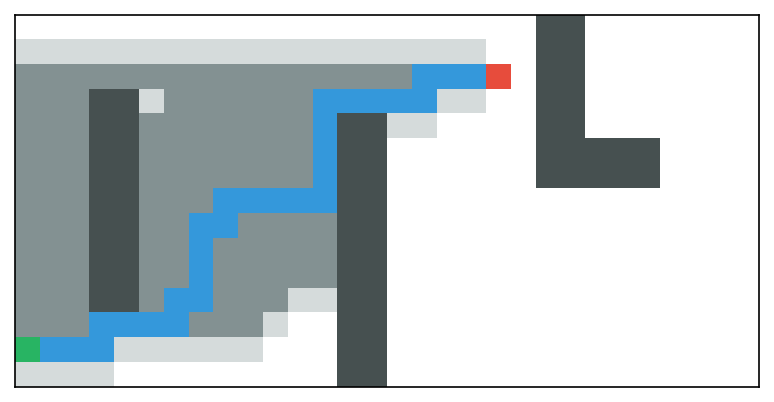

Path found! Length: 30. Search tree size: 227. Number of steps: 134. Correct: True
CPU times: user 32 ms, sys: 2.85 ms, total: 34.9 ms
Wall time: 34.2 ms


In [197]:
"""
The code should execute correctly if your A* implementation is accurate.
Experiment with the test instance number (the 2nd argument) to execute the search algorithm on various start/goal pairs.
"""
%time res = simple_test(astar, 1, manhattan_distance, SearchTreePQD)

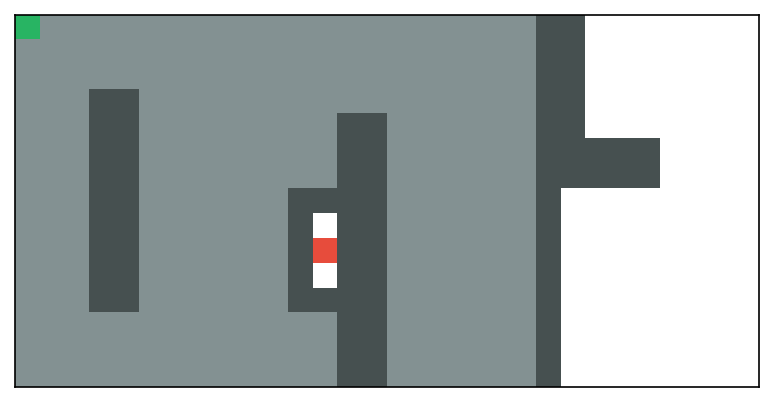

Path not found! Search tree size: 265. Number of steps: 266. Correct: True
CPU times: user 30.9 ms, sys: 2.87 ms, total: 33.8 ms
Wall time: 32.2 ms


In [198]:
"""
The code will execute correctly if the A* implementation properly handles cases where a path doesn't exist.
"""
%time res = simple_test_not_found(astar, 1, manhattan_distance, SearchTreePQD)

In [199]:
"""
Test the efficient implementation of A* on the complete set of large instances (9 in total). 
Every test should execute correctly.

On my modern laptop (2022 Asus, Intel iCore7, 16Gb RAM, SSD) the entire test finishes 
in about 3 seconds, which is about half the time taken by Dijkstra's algorithm in the previous lab.
"""

%time res = a_star_stat = massive_test(astar, "data/", 9, manhattan_distance, SearchTreePQD)

# for me this takes ~1.3s, Dijkstra ~2.4s

Task: #0. Path found! Length: 64. Search tree size: 807. Number of steps: 441. Correct: True
Task: #1. Path found! Length: 197. Search tree size: 3770. Number of steps: 3532. Correct: True
Task: #2. Path found! Length: 462. Search tree size: 26537. Number of steps: 17344. Correct: True


Task: #3. Path found! Length: 498. Search tree size: 27883. Number of steps: 27371. Correct: True
Task: #4. Path found! Length: 479. Search tree size: 24927. Number of steps: 23723. Correct: True
Task: #5. Path found! Length: 402. Search tree size: 11547. Number of steps: 7323. Correct: True
Task: #6. Path found! Length: 721. Search tree size: 75945. Number of steps: 75033. Correct: True
Task: #7. Path found! Length: 678. Search tree size: 51387. Number of steps: 49768. Correct: True
Task: #8. Path found! Length: 683. Search tree size: 47136. Number of steps: 28727. Correct: True
CPU times: user 1.44 s, sys: 17.8 ms, total: 1.46 s
Wall time: 1.47 s


The influence of tie-breaking criteria can significantly affect the performance of A*.

Let's implement two different secondary criteria (when the f-value is the same, we'll consider the g-value) and see which one performs better.


In [205]:
def lt_g_max(self, other):
    if self.f == other.f:
        return self.g > other.g
    return self.f < other.f


def lt_g_min(self, other):
    if self.f == other.f:
        return self.g < other.g
    return self.f < other.f

G_MAX (= H-MIN) tie-breaker


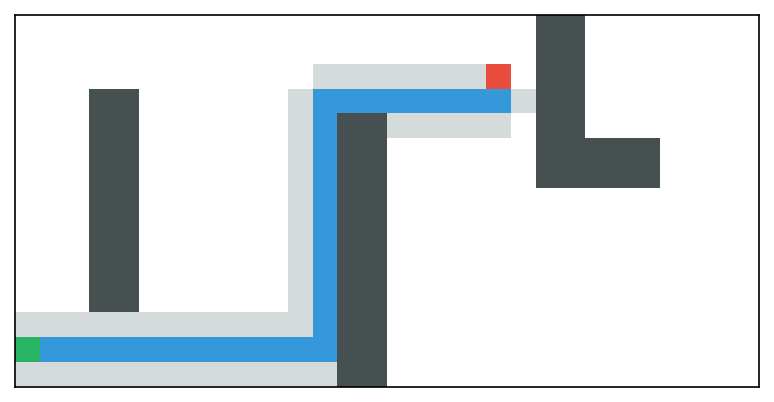

Path found! Length: 30. Search tree size: 78. Number of steps: 31. Correct: True
G_MIN (= H-MAX) tie-breaker


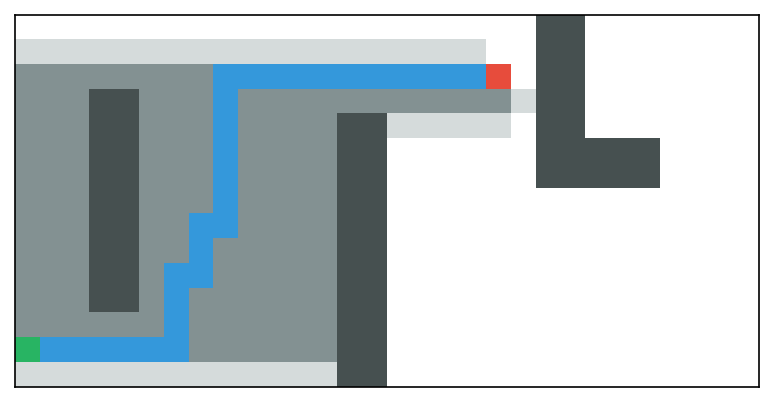

Path found! Length: 30. Search tree size: 190. Number of steps: 152. Correct: True


In [206]:
i = 1

print("G_MAX (= H-MIN) tie-breaker")
Node.__lt__ = lt_g_max
res1 = simple_test(astar, i, manhattan_distance, SearchTreePQD)

print("G_MIN (= H-MAX) tie-breaker")
Node.__lt__ = lt_g_min
res2 = simple_test(astar, i, manhattan_distance, SearchTreePQD)

## Run Massive Tests

<center><img src="./img/2.png"/></center>

In [207]:
Node.__lt__ = lt_g_max
%time g_max_results = massive_test(astar, "data/", 9, manhattan_distance, SearchTreePQD)

Task: #0. Path found! Length: 64. Search tree size: 178. Number of steps: 65. Correct: True
Task: #1. Path found! Length: 197. Search tree size: 3551. Number of steps: 3341. Correct: True
Task: #2. Path found! Length: 462. Search tree size: 4569. Number of steps: 2164. Correct: True
Task: #3. Path found! Length: 498. Search tree size: 27629. Number of steps: 27047. Correct: True
Task: #4. Path found! Length: 479. Search tree size: 25036. Number of steps: 23455. Correct: True
Task: #5. Path found! Length: 402. Search tree size: 5497. Number of steps: 3062. Correct: True
Task: #6. Path found! Length: 721. Search tree size: 75501. Number of steps: 74525. Correct: True
Task: #7. Path found! Length: 678. Search tree size: 50839. Number of steps: 48862. Correct: True
Task: #8. Path found! Length: 683. Search tree size: 56273. Number of steps: 28092. Correct: True
CPU times: user 1.4 s, sys: 17.2 ms, total: 1.42 s
Wall time: 1.42 s


In [208]:
Node.__lt__ = lt_g_min
%time g_min_results = massive_test(astar, "data/", 9, manhattan_distance, SearchTreePQD)

Task: #0. Path found! Length: 64. Search tree size: 1137. Number of steps: 1017. Correct: True
Task: #1. Path found! Length: 197. Search tree size: 3894. Number of steps: 3734. Correct: True
Task: #2. Path found! Length: 462. Search tree size: 22144. Number of steps: 21282. Correct: True
Task: #3. Path found! Length: 498. Search tree size: 27816. Number of steps: 27371. Correct: True
Task: #4. Path found! Length: 479. Search tree size: 25038. Number of steps: 24290. Correct: True
Task: #5. Path found! Length: 402. Search tree size: 11783. Number of steps: 11282. Correct: True
Task: #6. Path found! Length: 721. Search tree size: 75729. Number of steps: 75119. Correct: True


In [ ]:
g_min_steps = np.array(g_min_results["steps"]).mean()
g_max_steps = np.array(g_max_results["steps"]).mean()
g_min_st_size = np.array(g_min_results["st_size"]).mean()
g_max_st_size = np.array(g_max_results["st_size"]).mean()
print(f"{g_min_steps:.4f}, {g_max_steps:.4f}")
print(f"{g_min_st_size:.4f}, {g_max_st_size:.4f}")

29638.6667, 23401.4444
30264.3333, 27674.7778


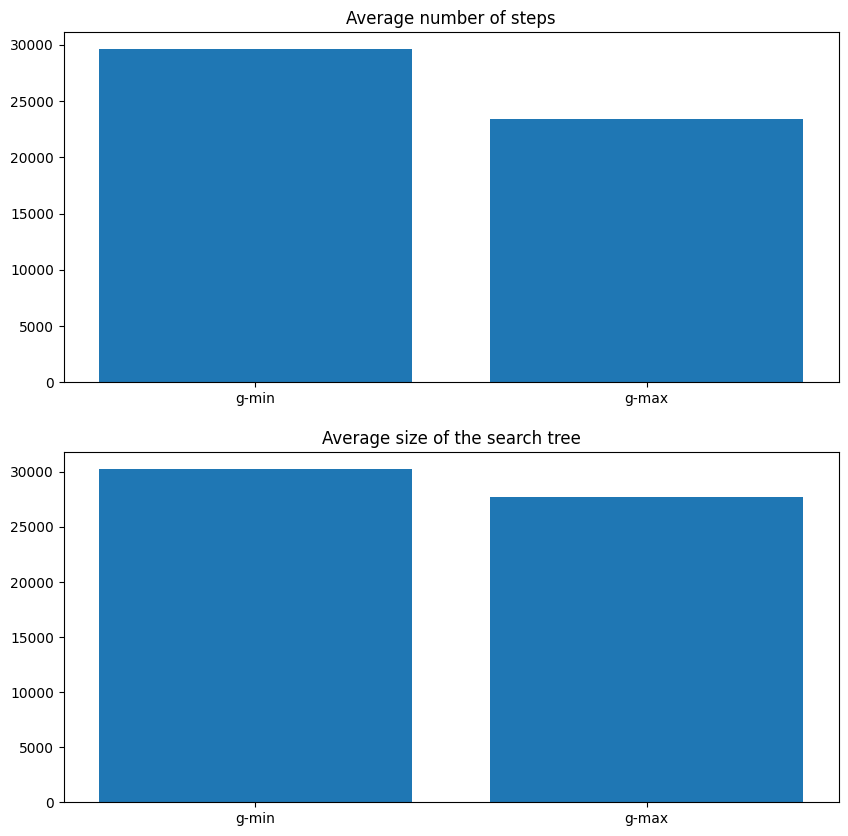

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].set_title("Average number of steps")
ax[1].set_title("Average size of the search tree")
ax[0].bar(["g-min", "g-max"], [g_min_steps, g_max_steps])
ax[1].bar(["g-min", "g-max"], [g_min_st_size, g_max_st_size]);